# Import und Analyse der Federspeicherdaten

* Importieren von Bibliotheken
* Laden Federspeicherdaten

In [4]:
# Betriebssystem
import os
# Plotbibliothek
import matplotlib
import matplotlib.pyplot as plt
# Effizientes Tabellenformat (DataFrames)
import pandas as pd
# Luxus-Plot für DataFrames
from pandas.plotting import scatter_matrix
# Numerik-Bibliothek
import numpy as np
import itertools
# Ausgewählte ML-Methoden aus Scikitlearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Plots sollen im Notebook erscheinen
%matplotlib inline

# Plot the decision plane between two classes
def plot_svc_decision_plane(ax, svm_clf, xmin, xmax, ymin, ymax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0 * x + w1*y + w2 * z + b = 0
    # => z = -w0/w2 * x -w1/w2 * y  - b/w2
    x = np.linspace(xmin, xmax, 10)
    y = np.linspace(ymin, ymax, 10)
    [X, Y] = np.meshgrid(x, y)
    decision_boundary = -w[0]/w[2] * X - w[1]/w[2] * Y - b/w[2]

    #svs = svm_clf.support_vectors_
    #plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    ax.plot_wireframe(X, Y, decision_boundary)#, "k-", linewidth=2)

## Challenge 1:

Daten laden und im DataFrame-Format nutzbar machen

In [5]:
# CSV vom Server laden
df = pd.read_csv("SpringPBData.csv")
# Unbenannte Index-Spalte umbenennen
df.rename(columns = {"Unnamed: 0":"Time"}, inplace = True)
# Datum-String in TimeStamp umwandeln und als Index verwenden
df.set_index(pd.to_datetime(df["Time"]), inplace = True)
# Time muss nach der Verwendung als Index nicht noch einmal in der Tabelle sein
df.drop(["Time", "x"], axis = 1, inplace = True)
# Tabelle anschauen
df.head()

,F,d,h1,h2,l
Time,,,,,
2017-10-26 07:30:00,18905.806965,0.005124,-0.047404,-0.031544,0.015860
2017-10-26 07:32:00,20026.385396,0.048496,0.008175,-0.014790,-0.022965
2017-10-26 07:34:00,19874.917201,-0.013561,0.046190,0.001044,-0.045146
2017-10-26 07:36:00,18058.438190,0.048965,-0.026648,-0.072617,-0.045969
2017-10-26 07:38:00,18187.872511,0.034729,-0.017012,-0.063248,-0.046235


Wie viele Federspeicher sind nicht OK?

Minimale Kraft $F = 18\, \mathrm{kN}$

In [6]:
df[df["F"] < 18000]["F"].count()

42

## Challenge 2:

Histogramm der Kräfte der Federspeicher anzeigen

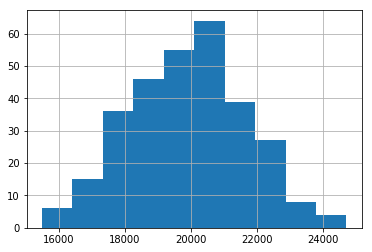

In [7]:
df["F"].hist()

**Gibt es Korrelationen zwischen den geometrischen Daten und der Kraft?**

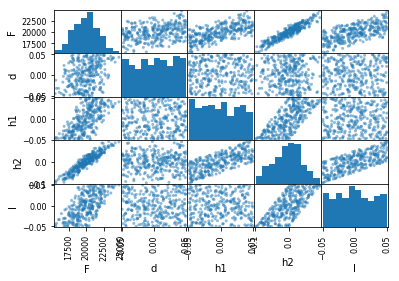

In [8]:
q = scatter_matrix(df)

** Vermutung: die geometrischen Daten genügen, die Konformität der Kraft vorherzusagen**

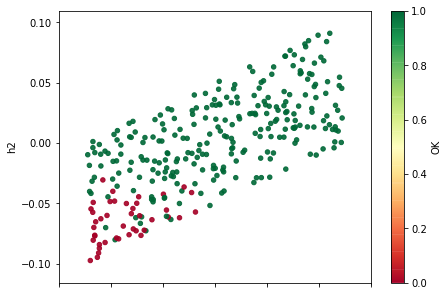

In [9]:
# Konforme Zylinder mit "OK = 1.0" labeln
Fmin = 18000
df["OK"] = 1.0*(df["F"] > Fmin)
# Im Scatterplot darstellen
df.plot(kind="scatter", y="h2", x="h1", alpha = 0.9, figsize=(7,5), c = "OK", cmap = "RdYlGn")

## Challenge 3:

Im Scatterplot kann keine Trennungsgerade gefunden werden, wir müssen höherdimensional werden!

### SVM trainieren

In [10]:
# Daten normalisieren mit Scaler, anlegen
scaler = StandardScaler()
# Welche Daten dienen als Grundlage?
X = df[['l', 'h1', 'h2']]
# Daten skalieren
X = scaler.fit_transform(X)
# Label training data
y = df['OK']
# Support Vector Machine initialisieren
svm_clf = SVC(kernel="linear")
# SVM trainieren
svm_clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

**Darstellung der Federspeicher-Eigenschaften und der Trennebene im 3D-Scatter**

Text(0.5,0,'$l$')

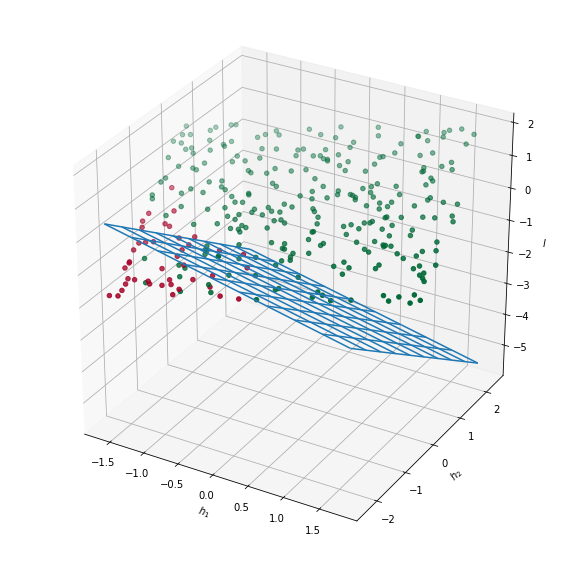

In [11]:
# Plot 3D scatter with decision boundary
from mpl_toolkits.mplot3d import Axes3D
x = X[:,1]
y = X[:,2]
z = X[:,0]
c = (df["F"]>Fmin)*1.0

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c = c, cmap = "RdYlGn")
plot_svc_decision_plane(ax, svm_clf, min(x), max(x), min(y), max(y))
ax.set_xlabel('$h_1$')
ax.set_ylabel('$h_2$')
ax.set_zlabel('$l$')

### Validieren der SVM

In [12]:
# Nicht zum Lernen verwendete Daten zum Testen laden
dfval = pd.read_csv("SpringPBDataValidation.csv")
# Daten aus dem Validierungsdatensatz auswählen
Xval = dfval[['l', 'h1', 'h2']]
# Transformation anwenden
Xval_scaled = scaler.transform(Xval)
# Vorhersage der Kraft des Federspeichers aus den geometrischen Daten
Fconf_pred = np.reshape((svm_clf.predict(Xval_scaled) == 1), (100, 1))
# Wahre Werte zum Vergleich
Fconf_true = (dfval["F"] > Fmin)

**Confusion matrix**

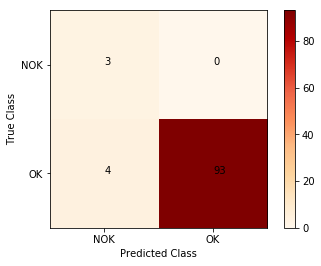

In [13]:
# Erstellen der Confusion Matrix mit SKlearn-Methode
conf_mat = confusion_matrix(Fconf_pred, Fconf_true)
# Etwas aufwendiger Plot für die Darstellung
plt.imshow(conf_mat, cmap = "OrRd")
plt.colorbar()
plt.xticks((0, 1), ("NOK", "OK"))
plt.yticks((0, 1), ("NOK", "OK"))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
for i,j in itertools.product((0,1), (0,1)):
    plt.text(j,i, conf_mat[i,j])